This notebook is mainly for messing around with Geopandas objects and figuring out what the best way is to plan a path


In [2]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np

In [3]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_1.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

In [4]:
# This cell parses the json data and obtains a list with the coordinates for each polygon like
# [[polygon1_coords],[polygon2_coords],....]
# where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
coordinates = []
for i in range(len(json_data['features'])):
    coordinates.append(json_data['features'][i]['geometry']['coordinates'])

In [5]:
# Here we create a geoseries object from the polygons 
polygon1 = gpd.GeoSeries(Polygon(coordinates[1][0]))
hole = gpd.GeoSeries(Polygon(coordinates[2][0]))
# Creating a buffer with a specific size (in this case 1)
obstacle_buffer = hole.buffer(1)
polygon1_buffer = polygon1.buffer(-1)

In [6]:
# Here we substract the hole from the field, the first line does this for the field and hole without headlands, the second line does it
# for field and hole with headlands

field = polygon1.symmetric_difference(hole)

field_with_headlands = polygon1_buffer.symmetric_difference(obstacle_buffer)

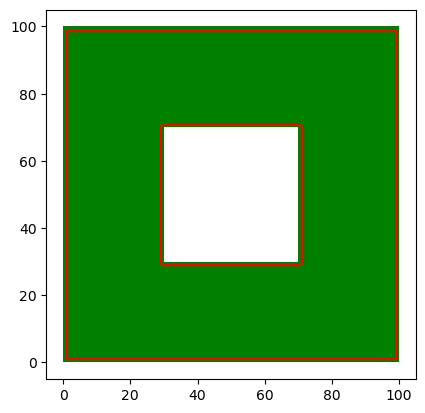

In [7]:
# Plotting the field (green) and headland boundaries
fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
plt.show()

In [8]:
# An easy way to obtain x and y coordinates for a polygon or polyline
polygon1.get_coordinates()

,x,y
0,0.0,0.0
0,0.0,100.0
0,100.0,100.0
0,100.0,0.0
0,0.0,0.0


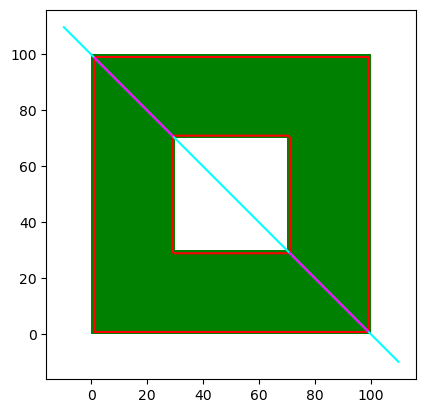

In [113]:
# Creating straight lines as vectors and clipping them to the field boundaries
vector = [[-10,110],[110,-10]]
# Here we make another geoseries object from the vector
swath = gpd.GeoSeries(LineString(vector))
# and we clip the vector so that it only covers the field and does not cross over into the headlands
swath_clipped = gpd.clip(swath,field_with_headlands)


# Plotting the original swath (cyan) and the clipped one (magenta)

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
swath.plot(ax = ax,color = 'cyan', marker = '+')
swath_clipped.plot(ax = ax, color = 'magenta')
plt.show()

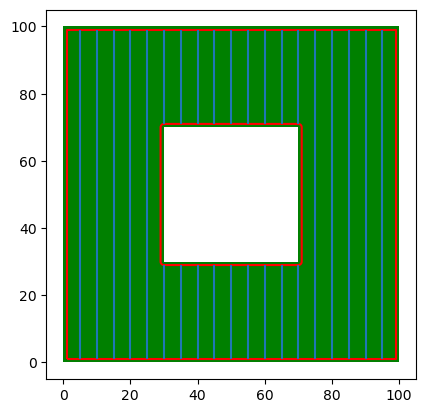

1484.0


In [112]:

# This cell combines the above cells and creates a bunch of parallel vectors with a fixed distance, clips them to the 
# boundaries of the field and then calculates the total length of the path

vector = []
for i in range(100):
    vector.append([[-0+i*5,100],[0+i*5,0]])

swaths = []
swaths_clipped = []
for i in range(len(vector)):
    swaths.append(gpd.GeoSeries(LineString(vector[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length

plt.show()
print(total_swath_length)